<a href="https://colab.research.google.com/github/educbd/Marketing/blob/main/Customer_Lifecycle_Value_(CLV).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction

## 1. Load libraries

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import plotly.express as px

# Libraries for ML modeling:
!pip install xgboost
!pip install lightgbm
from scipy import stats
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV
from math import sqrt

from sklearn.linear_model import Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')

## 2. Import the dataset

In [7]:
df = pd.read_csv('https://raw.githubusercontent.com/educbd/Marketing/main/Customer_Lifetime_Value_Dataset.csv')
df.head()

,customerid,firstpurchasedate,lastpurchasedate,totalpurchases,totalrevenue,referralsource,churnindicator,discountsused,productcategory,responsetolastcampaign,feedbackscore,preferredpaymentmethod,supportticketsraised,hasloyaltycard,frequency
0,8519,2021-12-31,2022-03-06,7,11670,Online advertisements,0,2,Q02,ignored,4.729998,debit card,0,no,7
1,38152,2019-09-27,2023-02-02,20,5260,Traditional media outreach,1,6,F76,purchased,4.184512,cash,0,no,2
2,19680,2021-06-13,2022-02-04,29,9790,Influencer endorsements,0,2,X04,opened mail,4.346640,google pay,0,no,4
3,35744,2021-07-28,2022-08-21,15,9591,Influencer endorsements,0,5,A25,ignored,5.000000,debit card,0,no,13
4,11663,2021-01-19,2022-03-10,13,10134,Word of mouth,0,3,A16,ignored,4.482089,credit card,0,no,11


## 3. Data Pre-Processing and Data Cleaning

### a. Create 'AvgPurchaseValue': Average value of purchases made by the customer (totalrevenue/totalpurchases)

In [8]:
# Create the 'AvgPurchaseValue' column
df['AvgPurchaseValue'] = df['totalrevenue'] / df['totalpurchases']

### b. Create 'Recency': Number of days since the last purchase

In [9]:
# Convert 'lastpurchasedate' to datetime format
df['lastpurchasedate'] = pd.to_datetime(df['lastpurchasedate'])

# Calculate the number of days since the last purchase
current_date = datetime.now()
df['Recency'] = (current_date - df['lastpurchasedate']).dt.days

### c. Create 'Tenure': Number of days since the customer's first purchase (useful for understanding how long they've been a customer)

In [10]:
# Convert 'firstpurchasedate' to datetime format
df['firstpurchasedate'] = pd.to_datetime(df['firstpurchasedate'])

# Calculate the number of days since the customer's first purchase
current_date = datetime.now()
df['Tenure'] = (current_date - df['firstpurchasedate']).dt.days

### d. Create 'AvgTimeBetweenPurchases': Average number of days between purchases

In [11]:
# Calculate total time span for each customer
df['TimeBetweenPurchases'] = (df['lastpurchasedate'] - df['firstpurchasedate']).dt.days

# Calculate average time between purchases
df['AvgTimeBetweenPurchases'] = (df['TimeBetweenPurchases'] / df['totalpurchases']).round(2)

## 4. Exploratory Data Analysis(EDA)

### a. Prelininary EDA:

In [12]:
# Display the first 5 rows of the DataFrame to understand its structure
df.head(5)

,customerid,firstpurchasedate,lastpurchasedate,totalpurchases,totalrevenue,referralsource,churnindicator,discountsused,productcategory,responsetolastcampaign,feedbackscore,preferredpaymentmethod,supportticketsraised,hasloyaltycard,frequency,AvgPurchaseValue,Recency,Tenure,TimeBetweenPurchases,AvgTimeBetweenPurchases
0,8519,2021-12-31,2022-03-06,7,11670,Online advertisements,0,2,Q02,ignored,4.729998,debit card,0,no,7,1667.142857,621,686,65,9.29
1,38152,2019-09-27,2023-02-02,20,5260,Traditional media outreach,1,6,F76,purchased,4.184512,cash,0,no,2,263.000000,288,1512,1224,61.20
2,19680,2021-06-13,2022-02-04,29,9790,Influencer endorsements,0,2,X04,opened mail,4.346640,google pay,0,no,4,337.586207,651,887,236,8.14
3,35744,2021-07-28,2022-08-21,15,9591,Influencer endorsements,0,5,A25,ignored,5.000000,debit card,0,no,13,639.400000,453,842,389,25.93
4,11663,2021-01-19,2022-03-10,13,10134,Word of mouth,0,3,A16,ignored,4.482089,credit card,0,no,11,779.538462,617,1032,415,31.92


In [13]:
df.shape

(10000, 20)

In [14]:
# Generate a report detailing the data types of each column in the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   customerid               10000 non-null  int64         
 1   firstpurchasedate        10000 non-null  datetime64[ns]
 2   lastpurchasedate         10000 non-null  datetime64[ns]
 3   totalpurchases           10000 non-null  int64         
 4   totalrevenue             10000 non-null  int64         
 5   referralsource           10000 non-null  object        
 6   churnindicator           10000 non-null  int64         
 7   discountsused            10000 non-null  int64         
 8   productcategory          10000 non-null  object        
 9   responsetolastcampaign   10000 non-null  object        
 10  feedbackscore            10000 non-null  float64       
 11  preferredpaymentmethod   10000 non-null  object        
 12  supportticketsraised     10000 no

In [15]:
categorical_features = df.select_dtypes(include=['object']).columns

In [16]:
# Display the number of unique values for each categorical column
for column in categorical_features:
    unique_count = df[column].nunique()
    print(f"Number of unique values for {column}: {unique_count}")

Number of unique values for referralsource: 8
Number of unique values for productcategory: 2552
Number of unique values for responsetolastcampaign: 3
Number of unique values for preferredpaymentmethod: 9
Number of unique values for supportticketsraised: 3
Number of unique values for hasloyaltycard: 2


In [17]:
# Break the data into numerical and categorical features
numeric_features = ['totalpurchases', 'totalrevenue', 'churnindicator', 'discountsused', 'feedbackscore', 'frequency', 'AvgPurchaseValue', 'Recency',	'Tenure',	'TimeBetweenPurchases', 'AvgTimeBetweenPurchases']
categorical_features = ['referralsource', 'responsetolastcampaign', 'preferredpaymentmethod', 'supportticketsraised', 'hasloyaltycard']

In [18]:
# Compute and display basic statistical summaries (mean, median, standard deviation, etc.) for all the numerical columns in the dataset.
df.describe()

,customerid,totalpurchases,totalrevenue,churnindicator,discountsused,feedbackscore,frequency,AvgPurchaseValue,Recency,Tenure,TimeBetweenPurchases,AvgTimeBetweenPurchases
count,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,27519.237400,19.28050,8521.876100,0.498700,2.993600,4.433905,10.053700,629.636381,630.028900,1183.549300,553.520400,34.666423
std,13118.347463,7.82962,2388.452322,0.500023,2.005283,0.920760,7.098652,816.565606,392.283779,392.949289,392.019992,44.310566
min,5000.000000,1.00000,4401.000000,0.000000,0.000000,1.006071,1.000000,123.150000,79.000000,84.000000,0.000000,0.000000
25%,16144.750000,13.00000,6427.750000,0.000000,1.000000,4.251318,4.000000,314.570238,299.000000,898.000000,224.000000,13.650000
50%,27617.000000,20.00000,8543.000000,0.000000,3.000000,4.985672,9.000000,435.362732,560.500000,1244.000000,485.000000,26.890000
75%,38967.250000,26.00000,10589.250000,1.000000,5.000000,5.000000,14.000000,649.432456,904.000000,1522.000000,828.000000,42.267500
max,49994.000000,40.00000,12678.000000,1.000000,6.000000,5.000000,31.000000,12658.000000,1727.000000,1747.000000,1663.000000,1479.000000


In [19]:
def sniff_modified(df):
    with pd.option_context("display.max_colwidth", 20):
        info = pd.DataFrame()
        info['sample'] = df.iloc[0]
        info['data type'] = df.dtypes
        info['percent missing'] = df.isnull().sum()*100/len(df)
        info['No. unique'] = df.apply(lambda x: len(x.unique()))
        info['unique values'] = df.apply(lambda x: x.unique())
        return info

In [20]:
sniff_modified(df)

,sample,data type,percent missing,No. unique,unique values
customerid,8519,int64,0.0,10000,"[8519, 38152, 19680, 35744, 11663, 23498, 2273..."
firstpurchasedate,2021-12-31 00:00:00,datetime64[ns],0.0,1526,"[2021-12-31T00:00:00.000000000, 2019-09-27T00:..."
lastpurchasedate,2022-03-06 00:00:00,datetime64[ns],0.0,1530,"[2022-03-06T00:00:00.000000000, 2023-02-02T00:..."
totalpurchases,7,int64,0.0,40,"[7, 20, 29, 15, 13, 8, 25, 26, 19, 23, 11, 16,..."
totalrevenue,11670,int64,0.0,5784,"[11670, 5260, 9790, 9591, 10134, 10665, 4866, ..."
referralsource,Online advertisements,object,0.0,8,"[Online advertisements, Traditional media outr..."
churnindicator,0,int64,0.0,2,"[0, 1]"
discountsused,2,int64,0.0,7,"[2, 6, 5, 3, 4, 1, 0]"
productcategory,Q02,object,0.0,2552,"[Q02, F76, X04, A25, A16, O25, V08, S31, Y30, ..."
responsetolastcampaign,ignored,object,0.0,3,"[ignored, purchased, opened mail]"


In [21]:
# Identify missing values in the dataset
df.isnull().sum()

customerid                 0
firstpurchasedate          0
lastpurchasedate           0
totalpurchases             0
totalrevenue               0
referralsource             0
churnindicator             0
discountsused              0
productcategory            0
responsetolastcampaign     0
feedbackscore              0
preferredpaymentmethod     0
supportticketsraised       0
hasloyaltycard             0
frequency                  0
AvgPurchaseValue           0
Recency                    0
Tenure                     0
TimeBetweenPurchases       0
AvgTimeBetweenPurchases    0
dtype: int64

In [22]:
# Check for Duplicates
print(f"The dataset contains **{df.duplicated().sum()}** duplicate rows.")

The dataset contains **0** duplicate rows.


In [23]:
# Check for Outliers
outliers = []
for i in numeric_features:
    outliers.extend(df[(df[i] < df[i].mean() - 3*df[i].std()) | (df[i] > df[i].mean() + 3*df[i].std())].index)

In [24]:
# Drop Outliers
df.drop(set(outliers),inplace = True)

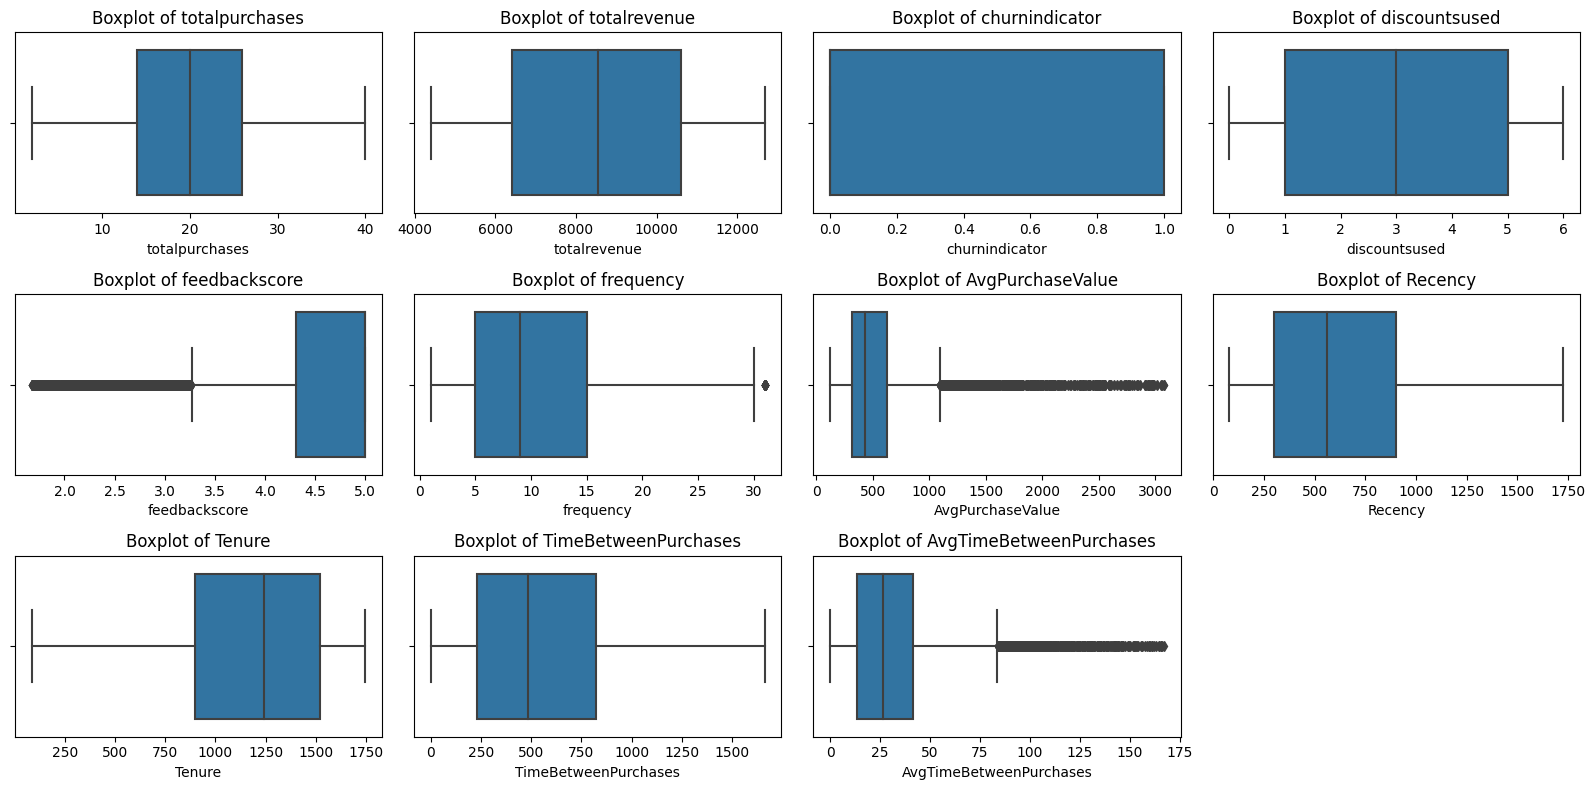

In [25]:
# Creating boxplots for each numeric feature
plt.figure(figsize=(16, 8))
for i, feature in enumerate(numeric_features, 1):
    plt.subplot(3, 4, i)
    sns.boxplot(x=df[feature])
    plt.title(f'Boxplot of {feature}')

plt.tight_layout()
plt.show()

In [26]:
df.shape

(9517, 20)

### b. Univariate Analysis:

#### i. Plot histograms for all numerical columns in the dataset

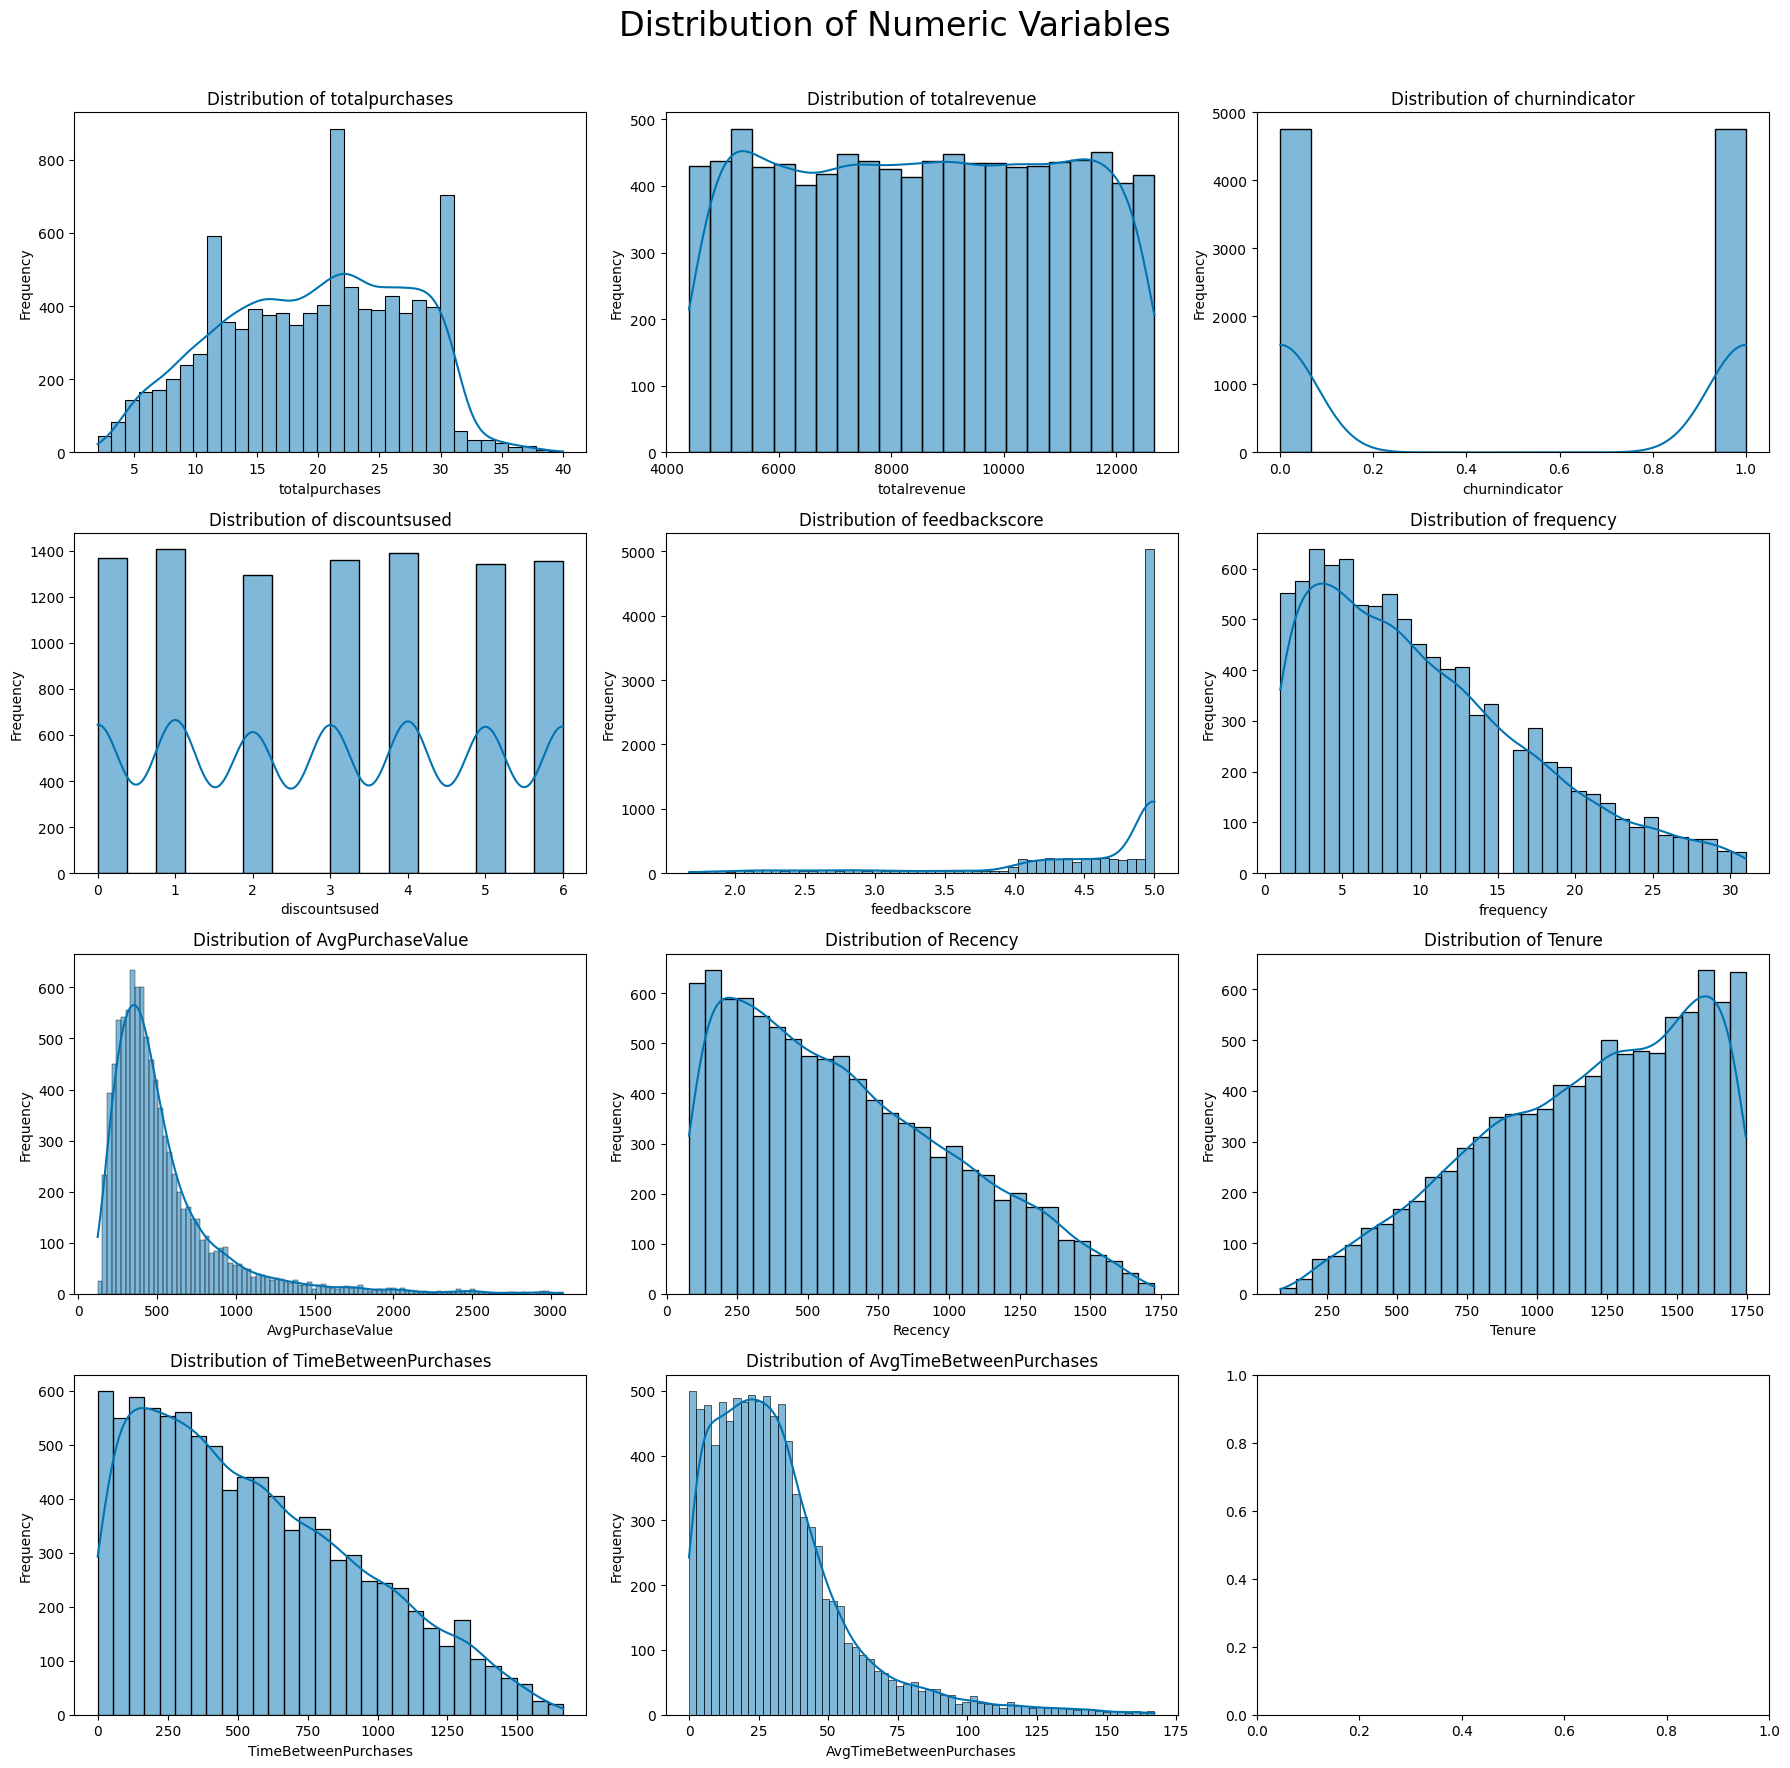

In [27]:
# Plot histograms for all numerical columns in the dataset

sns.set_palette(palette="colorblind")
fig, axes = plt.subplots(4, 3, figsize=(18, 18))
fig.suptitle("Distribution of Numeric Variables", size=24)

for i in range(4):
    for j in range(3):
        index = 3 * i + j
        if index < len(numeric_features):
            sns.histplot(df[numeric_features[index]], ax=axes[i, j], kde=True)
            axes[i, j].set_title(f'Distribution of {numeric_features[index]}')
            axes[i, j].set_xlabel(numeric_features[index])
            axes[i, j].set_ylabel('Frequency')

plt.tight_layout(rect=[0, 0, 1, 0.97])  # Adjust the layout
plt.show()

#### ii. For each categorical column, generate bar plots depicting the frequency of each category.

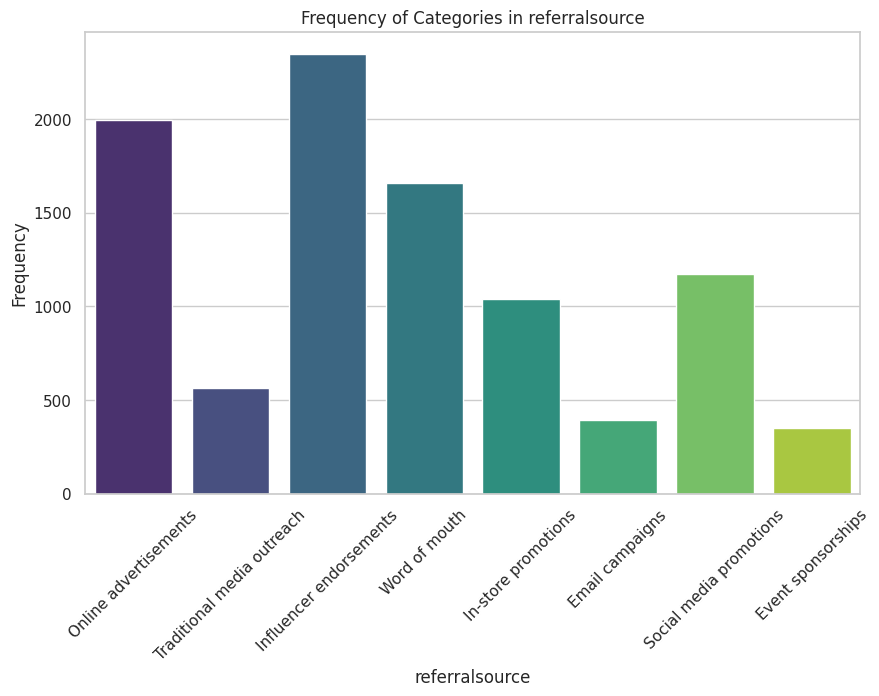

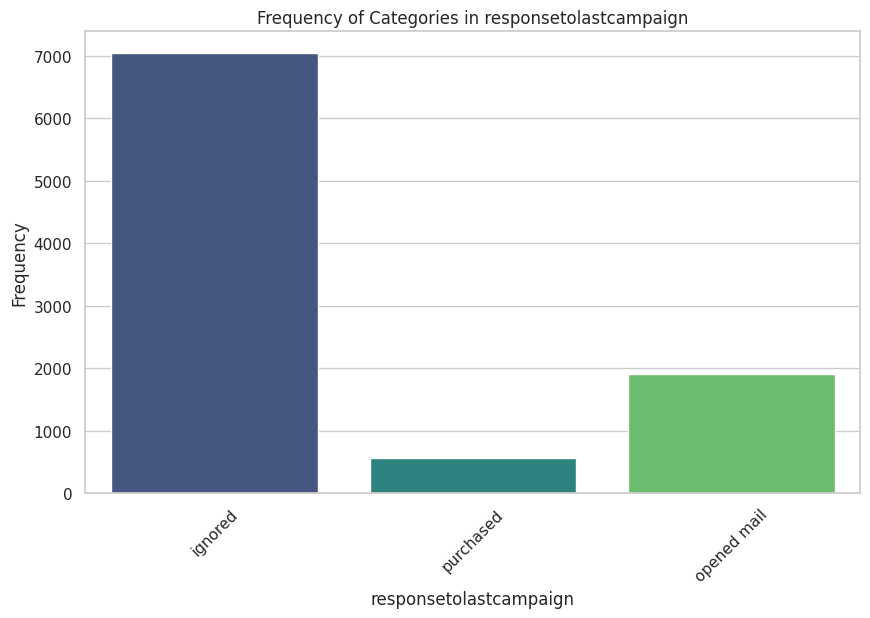

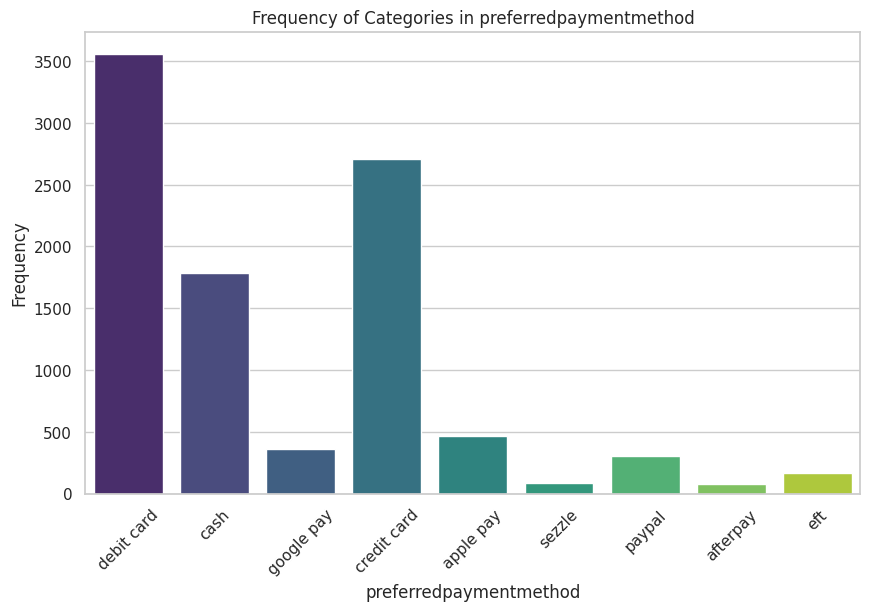

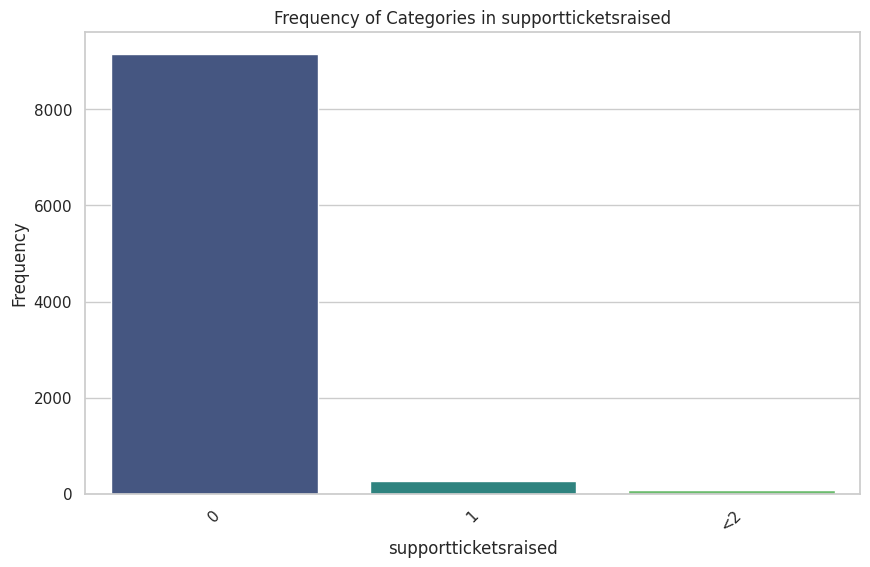

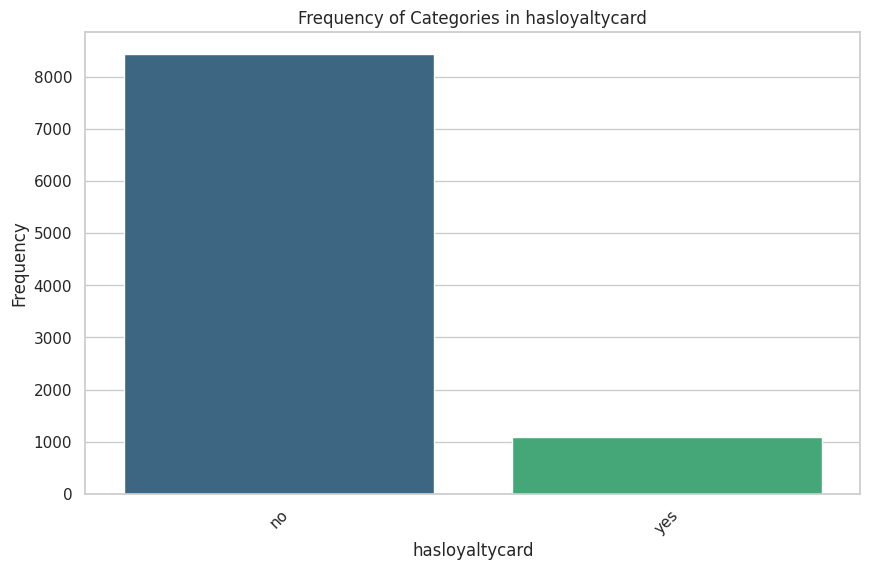

In [28]:
# Create bar plots for each categorical feature

sns.set(style="whitegrid")
for feature in categorical_features:
    plt.figure(figsize=(10, 6))  # Set the size of the plot
    sns.countplot(x=feature, data=df, palette="viridis")
    plt.title(f'Frequency of Categories in {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
    plt.show()

### c. Bivariate analysis:

#### i. Construct a correlation matrix for all the numerical features in the dataset.

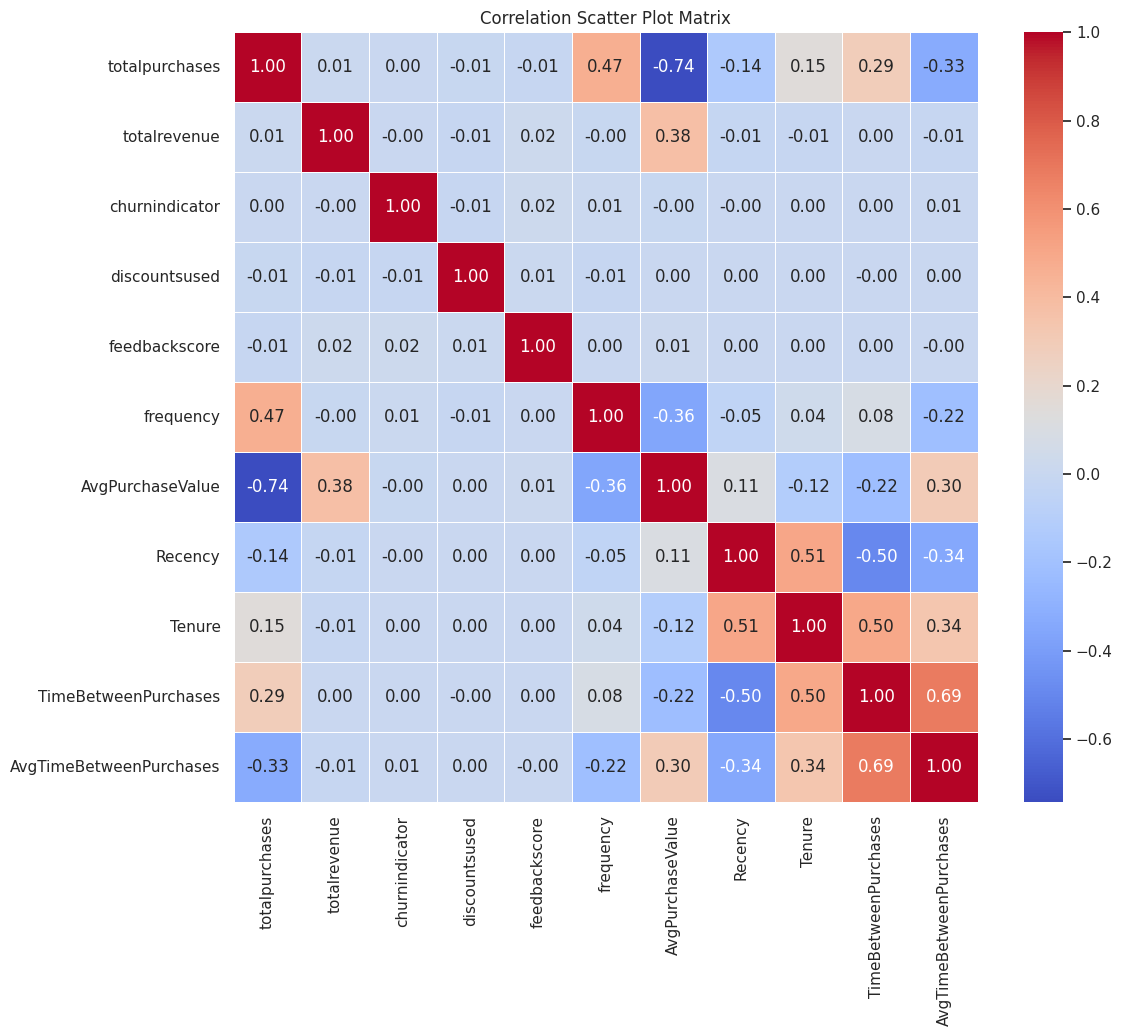

In [29]:
# Check for linearity between variables

# Create a subset DataFrame with only the numerical features
numerical_df = df[numeric_features]

# Calculate the correlation matrix
correlation_matrix = numerical_df.corr()

# Create a correlation scatter plot matrix
plt.figure(figsize=(12, 10))
sns.set(font_scale=1.0)
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Scatter Plot Matrix")

plt.show()

#### ii. Use box plots to compare the distribution of a chosen numerical column across different categories in the dataset.

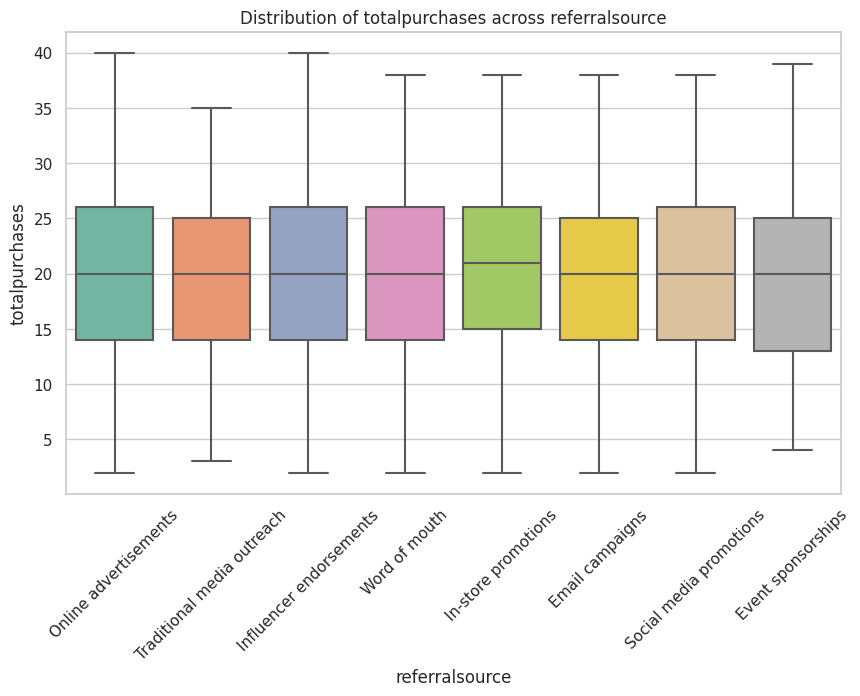

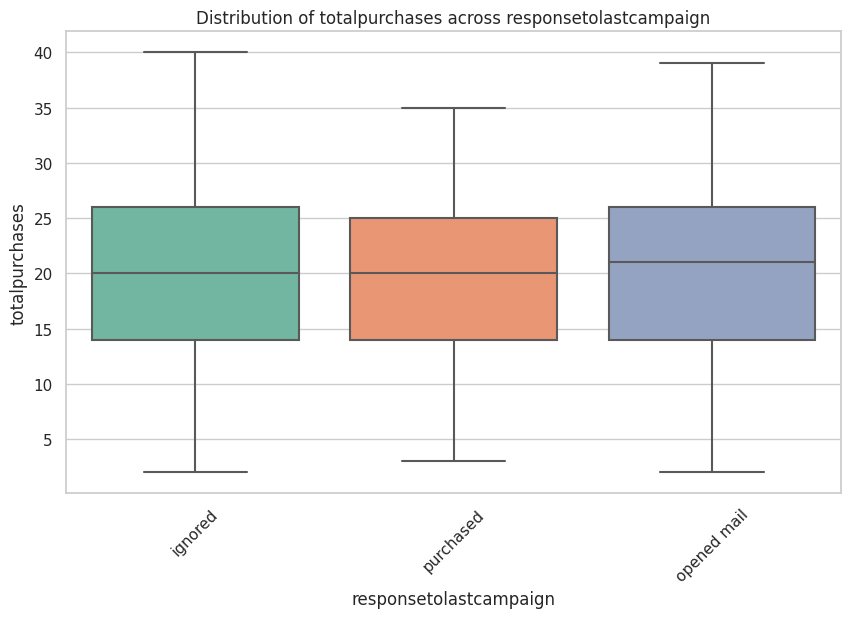

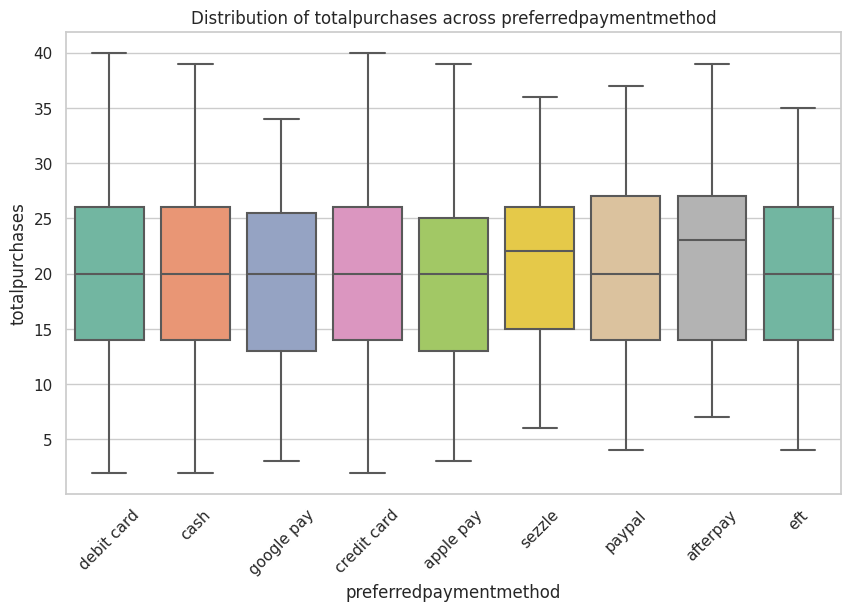

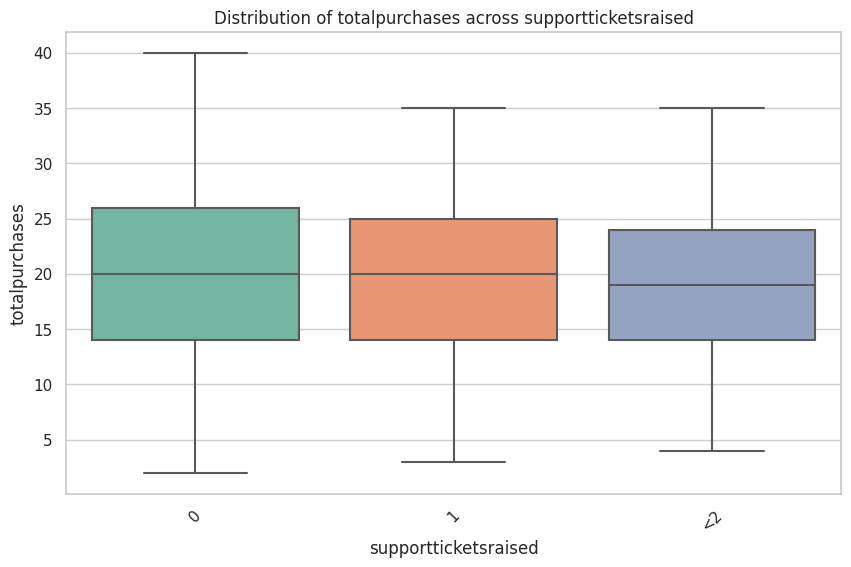

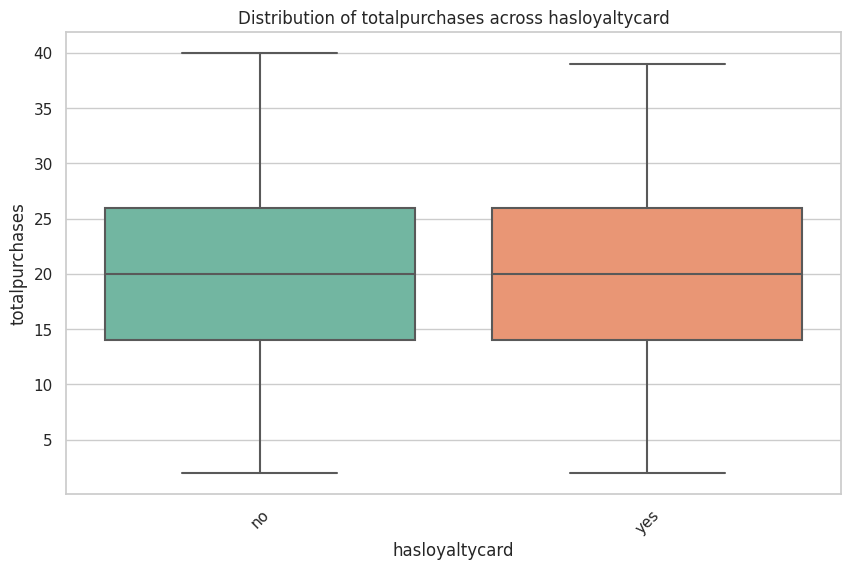

In [30]:
# Assuming 'totalpurchases' is the chosen numerical column
numerical_column = 'totalpurchases'

# Set the style for the plots (optional)
sns.set(style="whitegrid")

# Create box plots to compare the distribution of TotalRevenue across different categories
for feature in categorical_features:
    plt.figure(figsize=(10, 6))  # Set the size of the plot
    sns.boxplot(x=feature, y=numerical_column, data=df, palette="Set2")
    plt.title(f'Distribution of {numerical_column} across {feature}')
    plt.xlabel(feature)
    plt.ylabel(numerical_column)
    plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
    plt.show()

### d. Advanced analysis:

#### i. Use a pair plot to visualize relationships between a select set of columns (totalpurchases, totalrevenue, avgpurchasevalue, frequency).

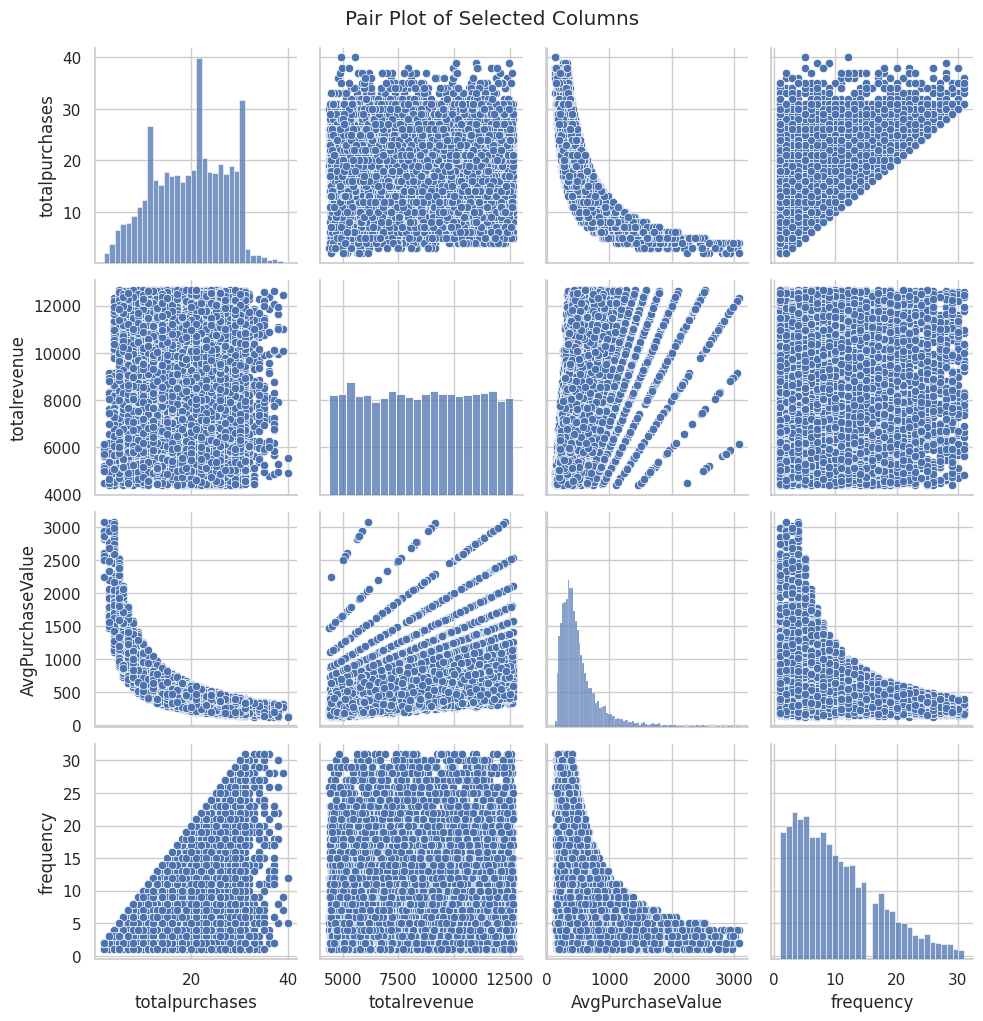

In [31]:
# Select the columns for the pair plot
selected_columns = ['totalpurchases', 'totalrevenue', 'AvgPurchaseValue', 'frequency']

# Create a pair plot
sns.pairplot(df[selected_columns])
plt.suptitle('Pair Plot of Selected Columns', y=1.02)
plt.show()

#### ii. Analyze the total revenue trend based on the year of the first purchase.

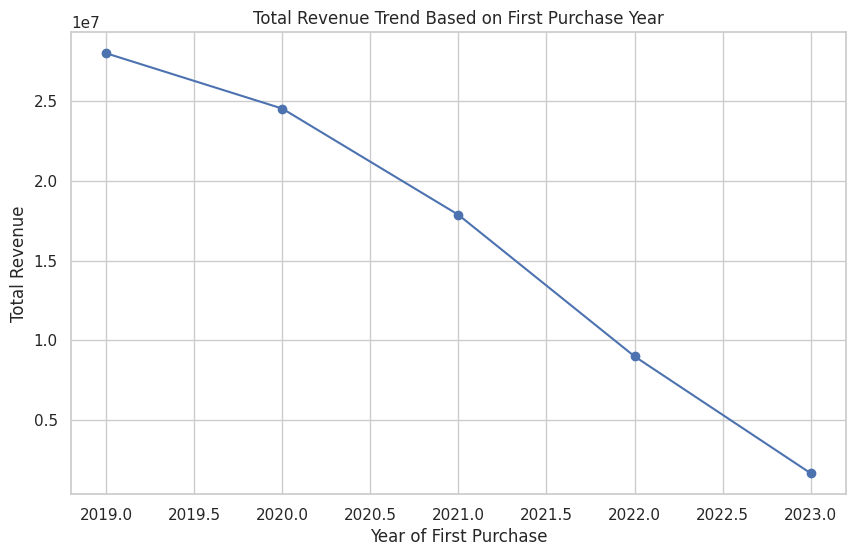

In [32]:
# Extract the year from 'firstpurchasedate'
df['first_purchase_year'] = df['firstpurchasedate'].dt.year

# Group by the year and calculate the total revenue for each year
revenue_trend = df.groupby('first_purchase_year')['totalrevenue'].sum().reset_index()

# Plot the total revenue trend
plt.figure(figsize=(10, 6))
plt.plot(revenue_trend['first_purchase_year'], revenue_trend['totalrevenue'], marker='o', linestyle='-')
plt.title('Total Revenue Trend Based on First Purchase Year')
plt.xlabel('Year of First Purchase')
plt.ylabel('Total Revenue')
plt.grid(True)
plt.show()

#### iii. Use the RFM (Recency, Frequency, Monetary) model to identify the top 5% of customers. List their customerid and associated RFM_Score.

last purchase date: recency


In [33]:
#Recency
df['Recency'] = df['Recency']

#Frequency
df['Frequency'] = df['frequency']

#Monetary
df['Monetary'] = df['totalrevenue']

# Display the Recency, Frequency, and Monetary for each customer
df[['customerid', 'Recency', 'Frequency', 'Monetary']]

,customerid,Recency,Frequency,Monetary
0,8519,621,7,11670
1,38152,288,2,5260
2,19680,651,4,9790
3,35744,453,13,9591
4,11663,617,11,10134
...,...,...,...,...
9995,21419,122,6,10023
9996,24140,865,11,5121
9997,32519,905,17,5962
9998,47248,824,1,5039


In [34]:
# Calculate RFM scores
df['R_Score'] = pd.qcut(df['Recency'], q=5, labels=False, duplicates='drop')
df['F_Score'] = pd.qcut(df['Frequency'], q=5, labels=False, duplicates='drop')
df['M_Score'] = pd.qcut(df['Monetary'], q=5, labels=False, duplicates='drop')

# Calculate RFM Score
df['RFM_Score'] = df['R_Score'] * 100 + df['F_Score'] * 10 + df['M_Score']

# Identify the top 5% of customers
top_5_percent_customers = df.nlargest(int(0.05 * len(df)), 'RFM_Score')

# Display customerid and associated RFM_Score for the top 5%
top_5_percent_customers[['customerid', 'RFM_Score']]

,customerid,RFM_Score
42,48461,444
86,11350,444
286,15424,444
651,47319,444
729,16444,444
...,...,...
4472,42550,432
4671,35324,432
4746,6464,432
4942,29328,432


### e. Multivariate analysis:

#### i. Create a scatter plot of totalrevenue vs. frequency and color the data points based on the churnindicator

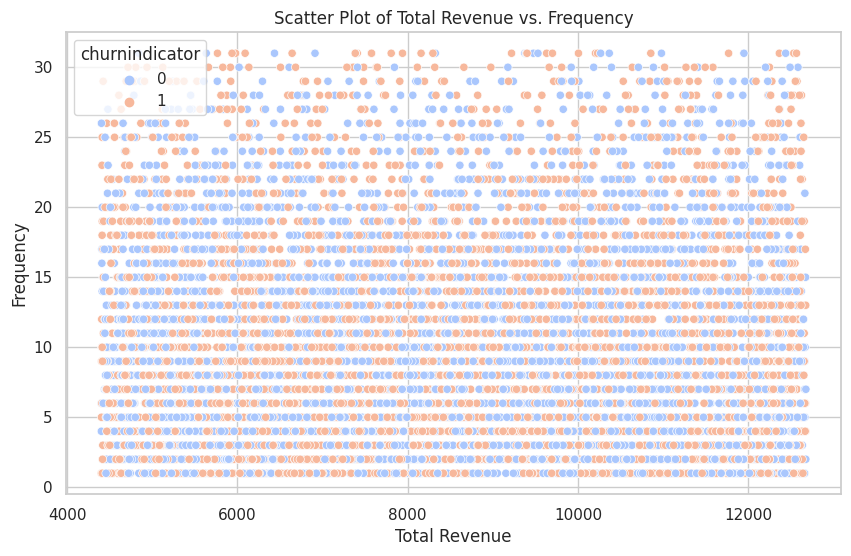

In [35]:
# Scatter plot with color based on churnindicator
plt.figure(figsize=(10, 6))
sns.scatterplot(x='totalrevenue', y='frequency', hue='churnindicator', data=df, palette='coolwarm')

# Add labels and title
plt.xlabel('Total Revenue')
plt.ylabel('Frequency')
plt.title('Scatter Plot of Total Revenue vs. Frequency')

# Display the plot
plt.show()

#### ii. Use the parallel coordinates plot to visualize multi-dimensional relationships using the columns totalpurchases, totalrevenue, avgpurchasevalue, frequency, and hasloyaltycard.

In [36]:
# Select columns for the parallel coordinates plot
selected_columns = ['totalpurchases', 'totalrevenue', 'AvgPurchaseValue', 'frequency', 'hasloyaltycard']

# Create a parallel coordinates plot
fig = px.parallel_coordinates(df, dimensions=selected_columns, color='totalpurchases', color_continuous_scale=px.colors.sequential.Viridis)

# Display the plot
fig.show()

## 5. Customer Lifetime Value (CLV) Modeling:

### a. Ridge regression
Method used to analyze any data that suffers from multicollinearity. This method performs L2 regularization.

In [37]:
# i. Load the dataset and split it into training and testing sets, keeping 20% of the data for testing.

X = df[['Recency', 'Frequency', 'AvgPurchaseValue']]
y = df['totalrevenue']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [38]:
# ii. Implement a Ridge Regression model using the provided features (`Recency`, `Frequency`, `AvgPurchaseValue`) to predict the `TotalRevenue`.

ridge0 = Ridge(alpha=0)
ridge0.fit(X_train, y_train)
y_pred0 = ridge0.predict(X_test)

In [39]:
# iii. Set the alpha parameter for Ridge Regression to 1.0. How does this value affect the coefficients of the model?

ridge1 = Ridge(alpha=1.0)
ridge1.fit(X_train, y_train)
y_pred1 = ridge1.predict(X_test)

How does this value affect the coefficients of the model?
> 'alpha'  controls the amount of Regularization applied to the model.
Regularization is a technique used to prevent overfitting by adding a penalty term to the loss function that the model optimizes.

In [40]:
# iv. Evaluate the model using Mean Squared Error (MSE) on the test set. Report the obtained value.

# Evaluation with alpha=0
# Calculate the Mean Absolute Error
mae = mean_absolute_error(y_test, y_pred0)
# Calculate the Mean Squared Error
mse = mean_squared_error(y_test, y_pred0)
print(f"MAE using alpha=0: {mae}")
print(f"MSE using alpha=0: {mse}")

# Evaluation with alpha=1
# Calculate the Mean Absolute Error
mae = mean_absolute_error(y_test, y_pred1)
# Calculate the Mean Squared Error
rr_mse = mean_squared_error(y_test, y_pred1)
print(f"MAE using alpha=1: {mae}")
print(f"MSE using alpha=1: {rr_mse}")

MAE using alpha=0: 1812.002958702003
MSE using alpha=0: 4580728.734413041
MAE using alpha=1: 1812.0030288097719
MSE using alpha=1: 4580728.829185468


### b. Random Forest Regressor

In [41]:
# i. Implement a Random Forest Regressor with 100 trees to predict the CLV.
rfr = RandomForestRegressor(n_estimators = 100)
rfr.fit(X_train, y_train)
y_pred_b = rfr.predict(X_test)

In [42]:
# ii. Using the feature importance attribute of the Random Forest model, list the features in order of their importance.

# Feature importance of the model
importances = rfr.feature_importances_

# Feature names from the dataset
feature_names = X_train.columns

# Create a DataFrame for easier manipulation
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Print the sorted DataFrame
print(importance_df)

            Feature  Importance
2  AvgPurchaseValue    0.631292
0           Recency    0.224567
1         Frequency    0.144141


In [43]:
# iii. Evaluate the model's performance using the test set. How does it compare to the Ridge Regression model?

# Calculate the Mean Absolute Error
mae = mean_absolute_error(y_test, y_pred_b)
# Calculate the Mean Squared Error
rfr_mse = mean_squared_error(y_test, y_pred_b)
# Calculate the Root Mean Squared Error
rmse = sqrt(mse)

# Print the metrics
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")


Mean Absolute Error (MAE): 1444.6430462184874
Mean Squared Error (MSE): 4580728.734413041


How does it compare to the Ridge Regression model?
>Comparing the two models, the Random Forest Regressor has a lower MSE than the Ridge Regression model, which suggests that it may be a better fit for this data.

### c. XGBoost

In [44]:
# i. Implement the XGBoost regressor to predict the CLV. Use 100 estimators for the model.

# Create a DMatrix from the training data
data_dmatrix = xgb.DMatrix(data=X_train,label=y_train)

# Define the parameters for the XGBoost model
xg_reg = xgb.XGBRegressor(n_estimators = 100)

# Fit the model to the training data
xg_reg.fit(X_train,y_train)

# Predict the 'totalrevenue' for the test data
preds = xg_reg.predict(X_test)

# Calculate the RMSE
rmse = np.sqrt(mean_squared_error(y_test, preds))
# Calculate the Mean Squared Error
xg_mse = mean_squared_error(y_test, preds)

print("RMSE: %f" % (rmse))
print("MSE: %f" % (mse))

RMSE: 1867.295484
MSE: 4580728.734413


In [45]:
# ii. XGBoost offers various hyperparameters to tune. Alter the learning rate of the model. How does it impact the model's performance?

# Define the parameters for your XGBoost model
xg_reg2 = xgb.XGBRegressor(learning_rate = 1.0, # Alter the learning rate of the model
                          n_estimators = 100)

# Fit the model to your training data
xg_reg2.fit(X_train,y_train)

# Predict the 'totalrevenue' for the test data
preds2 = xg_reg2.predict(X_test)

# Calculate the RMSE
rmse2 = np.sqrt(mean_squared_error(y_test, preds2))
# Calculate the Mean Squared Error
mse2 = mean_squared_error(y_test, preds2)

print("RMSE: %f" % (rmse2))
print("MSE: %f" % (mse2))

RMSE: 2209.195194
MSE: 4880543.403555


How does it impact the model's performance?
> The first model has a lower RMSE and MSE, which means it’s performing better than the second model. The lower the RMSE and MSE, the closer the model’s predictions are to the actual values, indicating a better fit.

In [46]:
# iii. Evaluate the model using the test data and compare its MSE with previous models.
print("MSE of Ridge Regression model: %f" % (rr_mse))
print("MSE of Random Forest Regressor model: %f" % (rfr_mse))
print("MSE of XGBoost model: %f" % (xg_mse))

MSE of Ridge Regression model: 4580728.829185
MSE of Random Forest Regressor model: 3455205.630471
MSE of XGBoost model: 3486792.424331


### d. Advanced Regression Model

In [47]:
# i. Train other regression models like Ridge, Lasso, Decision Trees, Random Forest, and Gradient Boosting to predict totalrevenue.

# A) Ridge Regression:
ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)

y_pred = ridge.predict(X_test)


# B) Lasso Regression::
lasso = Lasso(alpha=1.0)
lasso.fit(X_train, y_train)

y_pred = lasso.predict(X_test)


# C) Decision Trees:
tree = DecisionTreeRegressor()
tree.fit(X_train, y_train)

y_pred = tree.predict(X_test)


# D) Random Forest:
forest = RandomForestRegressor(n_estimators=100)
forest.fit(X_train, y_train)

y_pred = forest.predict(X_test)


# E) Gradient Boosting:
gbr = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=1)
gbr.fit(X_train, y_train)

y_pred = gbr.predict(X_test)

In [48]:
# ii. Use cross-validation for model selection and tuning.

# Define the models
models = [
    Ridge(alpha=1.0),
    Lasso(alpha=1.0),
    DecisionTreeRegressor(),
    RandomForestRegressor(n_estimators=100),
    GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=1)
]




# iii. Evaluate the models using the same metrics as before and compare their performances.

# Perform 5-fold cross-validation on each model
for model in models:
    scores = cross_val_score(model, X, y, cv=5)
    print(f'{model.__class__.__name__}: Average R^2 score: {np.mean(scores)}')


Ridge: Average R^2 score: 0.16153579024339687
Lasso: Average R^2 score: 0.16153588245577055
DecisionTreeRegressor: Average R^2 score: -0.11870890575313094
RandomForestRegressor: Average R^2 score: 0.3899065904143182
GradientBoostingRegressor: Average R^2 score: 0.40633784327766687


### e. [OPTIONAL] Hyperparameter Tuning

In [53]:
# i. For models that have hyperparameters, use techniques like GridSearchCV or RandomizedSearchCV to find optimal values.

parameters = {'alpha': [1e-15, 1e-10, 1e-8, 1e-4, 1e-3, 1e-2, 1, 5, 10, 20]}

# A) Ridge:
ridge_ht = Ridge()
ridge_regressor = GridSearchCV(ridge_ht, parameters, scoring='neg_mean_squared_error', cv=5)
ridge_regressor.fit(X, y)

# B) Lasso
lasso_ht = Lasso()
lasso_regressor = GridSearchCV(lasso_ht, parameters, scoring='neg_mean_squared_error', cv=5)
lasso_regressor.fit(X, y)

# C) Decision Tree
tree_ht = DecisionTreeRegressor()
parameters = {'max_depth': [5, 10, 15, 20, 25, 30]}
tree_regressor = RandomizedSearchCV(tree_ht, parameters, n_iter=100, cv=5, verbose=2, random_state=42, n_jobs=-1)
tree_regressor.fit(X, y)

# D) Random Forest
forest_ht = RandomForestRegressor()
parameters = {'n_estimators': [30, 60, 80, 100, 110], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, None]}
forest_regressor = RandomizedSearchCV(forest_ht, parameters, n_iter=30, cv=5, verbose=2, random_state=42, n_jobs=-1)
forest_regressor.fit(X, y)

# E) Gradient Boosting
gbr_ht = GradientBoostingRegressor()
parameters = {'n_estimators': [30, 60, 80, 100, 110], 'learning_rate': [0.1, 0.05, 0.02, 0.01], 'max_depth': [4, 6, 8]}
gbr_regressor = RandomizedSearchCV(gbr_ht, parameters, n_iter=30, cv=5, verbose=2, random_state=42, n_jobs=-1)
gbr_regressor.fit(X, y)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits


RandomizedSearchCV(cv=5, estimator=GradientBoostingRegressor(), n_iter=30,
                   n_jobs=-1,
                   param_distributions={'learning_rate': [0.1, 0.05, 0.02,
                                                          0.01],
                                        'max_depth': [4, 6, 8],
                                        'n_estimators': [30, 60, 80, 100, 110]},
                   random_state=42, verbose=2)

In [55]:
# ii. Re-evaluate the models using the optimized hyperparameters.

# A) Ridge:
scores_Aht = cross_val_score(ridge_regressor, X, y, cv=5)
print(f'ridge_regressor : Average R^2 score: {np.mean(scores_Aht)}')

# B) Lasso:
scores_Bht = cross_val_score(lasso_regressor, X, y, cv=5)
print(f'lasso_regressor: Average R^2 score: {np.mean(scores_Bht)}')

# C) Decision Tree
scores_Cht = cross_val_score(tree_regressor, X, y, cv=5)
print(f'tree_regressor: Average R^2 score: {np.mean(scores_Cht)}')

# D) Random Forest
scores_Dht = cross_val_score(forest_regressor, X, y, cv=5)
print(f'forest_regressor: Average R^2 score: {np.mean(scores_Dht)}')

# E) Gradient Boosting
scores_Eht = cross_val_score(gbr_regressor, X, y, cv=5)
print(f'gbr_regressor: Average R^2 score: {np.mean(scores_Eht)}')



ridge_regressor : Average R^2 score: -4780804.551396394
lasso_regressor: Average R^2 score: -4780816.78831275
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
tree_regressor: Average R^2 score: 0.42077018620470763
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits
forest_regressor: Average R^2 score: 0.44605792245816256
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, t

### f. Feature Importance

In [62]:
# i. For tree-based models like Random Forest and Gradient Boosting, extract feature importance scores.


# Random Forest
forest_importances = forest_regressor.best_estimator_.feature_importances_
# Get feature names
feature_names = X.columns.tolist()
# Print the feature ranking for Random Forest
print("Feature ranking for Random Forest:")

for f in range(X.shape[1]):
    print(f"{f + 1}. feature {feature_names[f]} ({forest_importances[f]})")


# Gradient Boosting
gbr_importances = gbr_regressor.best_estimator_.feature_importances_
# Print the feature ranking for Gradient Boosting
print("Feature ranking for Gradient Boosting:")

for f in range(X.shape[1]):
    print(f"{f + 1}. feature {feature_names[f]} ({gbr_importances[f]})")

Feature ranking for Random Forest:
1. feature Recency (0.08557477364864671)
2. feature Frequency (0.13015278743795541)
3. feature AvgPurchaseValue (0.7842724389133979)
Feature ranking for Gradient Boosting:
1. feature Recency (0.02488717359352634)
2. feature Frequency (0.12989347827118464)
3. feature AvgPurchaseValue (0.845219348135289)


In [ ]:
# ii. Analyze and interpret the top features affecting totalrevenue.

```
ii. Analyze and interpret the top features affecting totalrevenue.

```

The feature importance scores indicate the relative importance of each feature in predicting the totalrevenue. The higher the score, the more important the feature is.

For the Random Forest model:

> **AvgPurchaseValue** is the most important feature with a score of 0.7843, indicating that it has the strongest effect on totalrevenue. This suggests that customers who spend more on average per purchase tend to generate more revenue.

>**Recency** is the least important feature with a score of 0.0856, implying that the time since the customer’s last purchase has the least impact on totalrevenue.


For the Gradient Boosting model:

> **AvgPurchaseValue** is again the most important feature with an even higher score of 0.8452, reinforcing the idea that the average amount a customer spends per purchase is a strong predictor of totalrevenue.

>**Recency** is again the least important feature with a score of 0.0249, which is lower than in the Random Forest model, suggesting that it has even less impact on totalrevenue in this model.



### g. Model Interpretation

In [50]:
# i. Use techniques like SHAP (SHapley Additive exPlanations) to explain model predictions.